## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we use Grad-CAM, which highlights the regions of the input image that were important for the neural network prediction.


* NB: if `PIL` is not installed, try `conda install pillow`.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import pickle
import urllib.request

import numpy as np
from PIL import Image

%matplotlib inline

### Download the Model
We provide you a pretrained model `ResNet-34` for `ImageNet` classification dataset.
* **ImageNet**: A large dataset of photographs with 1 000 classes.
* **ResNet-34**: A deep architecture for image classification.

In [ ]:
resnet34 = models.resnet34(pretrained=True)
resnet34.eval() # set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

![ResNet34](https://miro.medium.com/max/1050/1*Y-u7dH4WC-dXyn9jOG4w0w.png)


Input image must be of size (3x224x224). 

First convolution layer with maxpool. 
Then 4 ResNet blocks. 

Output of the last ResNet block is of size (512x7x7). 

Average pooling is applied to this layer to have a 1D array of 512 features fed to a linear layer that outputs 1000 values (one for each class). No softmax is present in this case. We have already the raw class score!

In [ ]:
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

##classes is a dictionary with the name of each class 
print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

### Input Images
We provide you 20 images from ImageNet (download link on the webpage of the course or download directly using the following command line,).<br>
In order to use the pretrained model resnet34, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [ ]:
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [ ]:
# The images should be in a *sub*-folder of "data/" (ex: data/TP2_images/images.jpg) and *not* directly in "data/"!
# otherwise the function won't find them

import os
os.makedirs("data", exist_ok = True)
os.makedirs("data/TP2_images", exist_ok = True)
!cd data/TP2_images && wget "https://www.lri.fr/~gcharpia/deeppractice/2023/TP2/TP2_images.zip" && unzip TP2_images.zip
dir_path = "data/" 
dataset = preprocess_image(dir_path)

--2023-02-13 21:05:10--  https://www.lri.fr/~gcharpia/deeppractice/2023/TP2/TP2_images.zip
Resolving www.lri.fr (www.lri.fr)... 129.175.15.11
Connecting to www.lri.fr (www.lri.fr)|129.175.15.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1477062 (1.4M) [application/zip]
Saving to: ‘TP2_images.zip.4’

TP2_images.zip.4    100%[===================>]   1.41M  2.89MB/s    in 0.5s    

2023-02-13 21:05:11 (2.89 MB/s) - ‘TP2_images.zip.4’ saved [1477062/1477062]

Archive:  TP2_images.zip
replace 155881293_721e90b57d.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: 155881293_721e90b57d.jpg  
  inflating: 158850087_3251644046.jpg  
  inflating: 1624593475_146bf1f7ff.jpg  
  inflating: 181748579_01a4611736.jpg  
  inflating: 2068921624_ef0986de13.jpg  
  inflating: 2637374064_fab14ec0b8.jpg  
  inflating: 2749465889_8e62023674.jpg  
  inflating: 2936812850_23bf0d1cfd.jpg  
  inflating: 3532471222_a6d7e3780e.jpg  
  inflating: 3633913271_ee789a3bc4.jpg  
  i

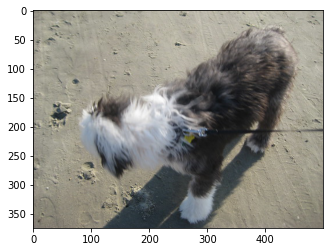

In [ ]:
# show the orignal image 
index = 2
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

In [ ]:
output = resnet34(dataset[index][0].view(1, 3, 224, 224))
values, indices = torch.topk(output, 3)
print("Top 3-classes:", indices[0].numpy(), [classes[x] for x in indices[0].numpy()])
print("Raw class scores:", values[0].detach().numpy())

Top 3-classes: [200 229 155] ['Tibetan terrier, chrysanthemum dog', 'Old English sheepdog, bobtail', 'Shih-Tzu']
Raw class scores: [10.186099  8.509345  8.472933]


### Grad-CAM 
* **Overview:** Given an image, and a category (‘tiger cat’) as input, we forward-propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the given images. For each image, choose the top-3 possible labels as the desired classes. Compare the heatmaps of the three classes, and conclude. 


* **To be submitted within 2 weeks**: this notebook, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully. 
 + The pretrained model resnet34 doesn't have an activation function after its last layer, the output is indeed the `raw class scores`, you can use them directly. 
 + The size of feature maps is 7x7, so your heatmap will have the same size. You need to project the heatmap to the resized image (224x224, not the original one, before the normalization) to have a better observation. The function [`torch.nn.functional.interpolate`](https://pytorch.org/docs/stable/nn.functional.html?highlight=interpolate#torch.nn.functional.interpolate) may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

Class: ‘pug, pug-dog’ | Class: ‘tabby, tabby cat’
- | - 
![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/dog.jpg)| ![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/cat.jpg)

In [ ]:
class GradCamModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None
        
        #PRETRAINED MODEL
        self.pretrained = models.resnet34(pretrained=True)
        self.layerhook.append(self.pretrained.layer4.register_forward_hook(self.forward_hook()))
        
        for p in self.pretrained.parameters():
            p.requires_grad = True
    
    def activations_hook(self,grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients

    def forward_hook(self):
        def hook(module, inp, out):
            self.selected_out = out
            self.tensorhook.append(out.register_hook(self.activations_hook))
        return hook

    def forward(self,x):
        out = self.pretrained(x)
        return out, self.selected_out



In [ ]:
model = GradCamModel().cpu()

In [ ]:
img = dataset[index][0].view(1, 3, 224, 224)

In [ ]:
mean=np.array([0.485, 0.456, 0.406])
std=np.array([0.229, 0.224, 0.225])

In [ ]:
img_np = ( np.array(img[0]).transpose(1,2,0) * std ) + mean

In [ ]:
out, acts = model(img)
acts = acts.detach().cpu()
loss = nn.CrossEntropyLoss()(out,torch.from_numpy(np.array([600])))
loss.backward()
grads = model.get_act_grads().detach().cpu()
pooled_grads = torch.mean(grads, dim=[0,2,3]).detach().cpu()
for i in range(acts.shape[1]):
 acts[:,i,:,:] += pooled_grads[i]
heatmap_j = torch.mean(acts, dim = 1).squeeze()
heatmap_j_max = heatmap_j.max(axis = 0)[0]
heatmap_j /= heatmap_j_max

In [ ]:
model = GradCamModel()
out, acts = model(img)
acts = acts.detach().cpu()
loss = nn.CrossEntropyLoss()(out,torch.from_numpy(np.array([600])))
loss.backward()
grads = model.get_act_grads().detach().cpu()
pooled_grads = torch.mean(grads, dim=[0,2,3]).detach().cpu()

heatmaps = []
for i in range(3):
  acts[:,i,:,:] += pooled_grads[i]
  heatmap = torch.mean(acts, dim = 1).squeeze()
  heatmap_max = heatmap.max(axis = 0)[0]
  heatmap = 255 * (heatmap/heatmap_max)
  heatmaps.append(heatmap)


#Top predticted classes
output = resnet34(img)
values, indices = torch.topk(output, 3)
top_class = [classes[x] for x in indices[0].numpy()]

In [ ]:
from skimage.io import imread
from skimage.transform import resize
import matplotlib as mpl
import matplotlib.pyplot as plt

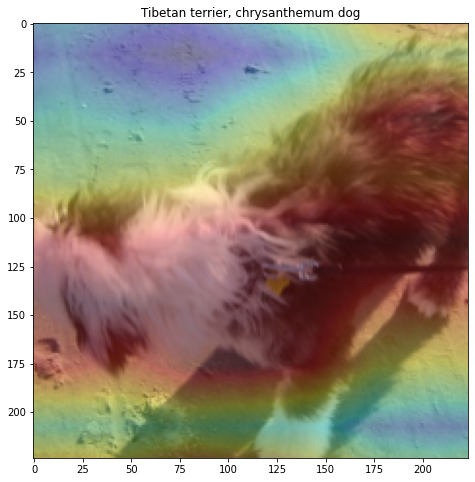

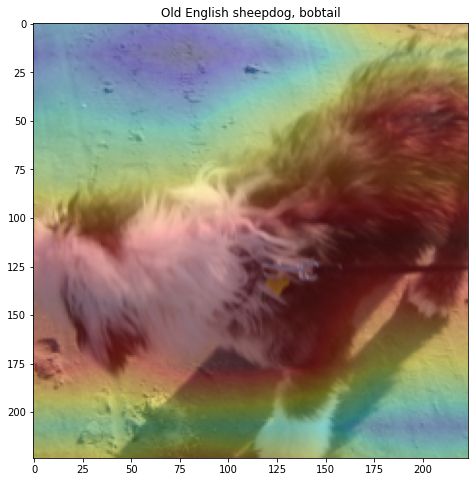

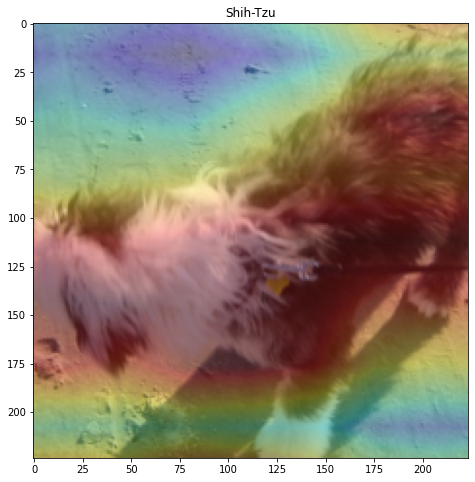

In [ ]:
i = 0
for map in heatmaps:

  map = resize(map,(224,224))
  fig, axs = plt.subplots(1,1,figsize = (8,8))
  plt.title(top_class[i])
  axs.imshow(img_np)
  axs.imshow(map, alpha=0.3, cmap='jet')
  plt.show()
  i += 1